# Computational Scattering

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Circle

# Size plots & labels
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 14

In [2]:
# Calculation of the acceleration due to the Coloumb potential - eq. (5) & (2)
def Coloumb_acceleration(x,y):
    r3 = (x**2 + y**2)**(3/2)
    return np.array([x/r3, y/r3])

In [3]:
# Calculation of the acceleration due to the chaotic potential - eq. (8)
def chaotic_accelertion(x,y):
    dVdx = 2*x * y**2 * np.exp(-x**2 - y**2)
    dVdy = (-2*y + 2*y**3) * np.exp(-x**2 - y**2)
    return np.array([-dVdx, -dVdy])

In [4]:
# Calculation of the next step through RK4
def RK4_step(state_n, h, acceleration, repulsive=True):
    def k(params):
        x, y, vx, vy = params
        ax, ay = acceleration(x,y) if repulsive else -acceleration(x,y)   # else, attractive potential i.e. attractive acceleration
        return np.array([vx, vy, ax, ay])
    k1 = k(state_n)   # state_n = r_n, v_n when wanting to calculate r_(n+1), v_(n+1)
    k2 = k(state_n + k1*h/2)
    k3 = k(state_n + k2*h/2)
    k4 = k(state_n + k3*h)
    return state_n + h/6 * (k1 + 2*k2 + 2*k3 + k4)   # returns state_(n+1) i.e. r_(n+1), v_(n+1)

# Obtain all the states at each step through RK4
def RK4(state, data, acceleration, rmax, energies=None, obtain_energies=False, repulsive=True):
    inside = False   # Only start counting once inside the circle of r=rmax
    while True:
        r = np.sqrt(state[0]**2 + state[1]**2)
        if r <= rmax: inside = True
        elif inside: break   # particle has exited the circle

        state = RK4_step(state, h, acceleration, repulsive)
        data.append(state.copy())
        if obtain_energies and energies is not None:
            energies.append(total_energy(state))
    return np.array(data) if not obtain_energies else (np.array(data), energies)


In [5]:
# Calculate the total energy
def total_energy(state, repulsive=True):
    x, y, vx, vy = state
    r = np.sqrt(x**2 + y**2)
    V = 1/r if repulsive else -1/r   # else, attractive potential
    K = 1/2 * (vx**2 + vy**2)
    return K + V

## Positron-positron scattering

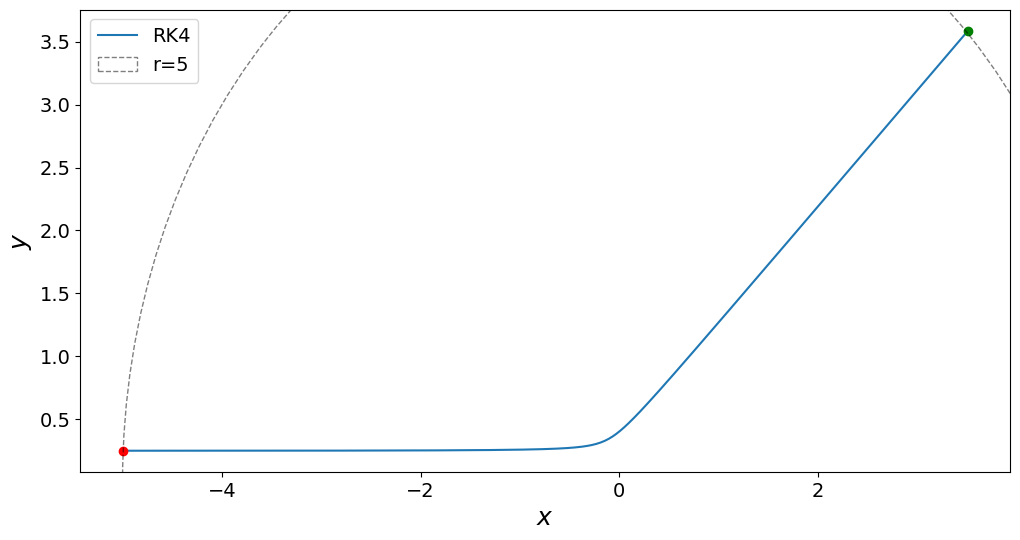

In [6]:
# Set initial conditions
E, b = 5, 0.25
h = 0.01
x0, y0 = -5, b
vx0, vy0 = np.sqrt(2*E), 0
state = np.array([x0, y0, vx0, vy0])

# Initialize and record the data using RK4
data = [state.copy()]
data = RK4(state, data, Coloumb_acceleration, rmax=5)

# Plot
plt.plot(data[:,0], data[:,1], zorder=0, label='RK4')
plt.scatter(data[0,0], data[0,1], color='r')
plt.scatter(data[-1,0], data[-1,1], color='g')
circle = plt.Circle((0,0), 5, fill=False, color='k', linestyle='--', alpha=0.5, label='r=5')
plt.gca().add_artist(circle)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.show()

### a) Transit time and scattering angle of the particle

The transit time is the time step times the number of steps taken meanwhile the angle of scattering is the angle between the direction of the final velocity and the direction of the initial velocity (which was all along its x component).

In [7]:
transit_time = len(data) * h
scattering_angle = np.arctan2(data[-1,3], data[-1,2])   # np.arctan() does element-wise, np.arctan2() not

print(f"The transit time is {transit_time:.4g} dimensionless units of time.\nThe scattering angle is {scattering_angle:.4g} rad, {np.degrees(scattering_angle):.4g}º")

The transit time is 3.27 dimensionless units of time.
The scattering angle is 0.7466 rad, 42.78º


### b) How the accuracy of the solution improves as the time step is reduced

With a lower time step the accuracy improves but it also causes the computation time to increase. Although in this example computation time is not an issue due to the small size of the region studied, a timestep of $h=\Delta t=0.01$ is a great choice as it has a maximum deviation on the energies of -7 orders of magnitude with respect to the energy itself while keeping a low computational time. 

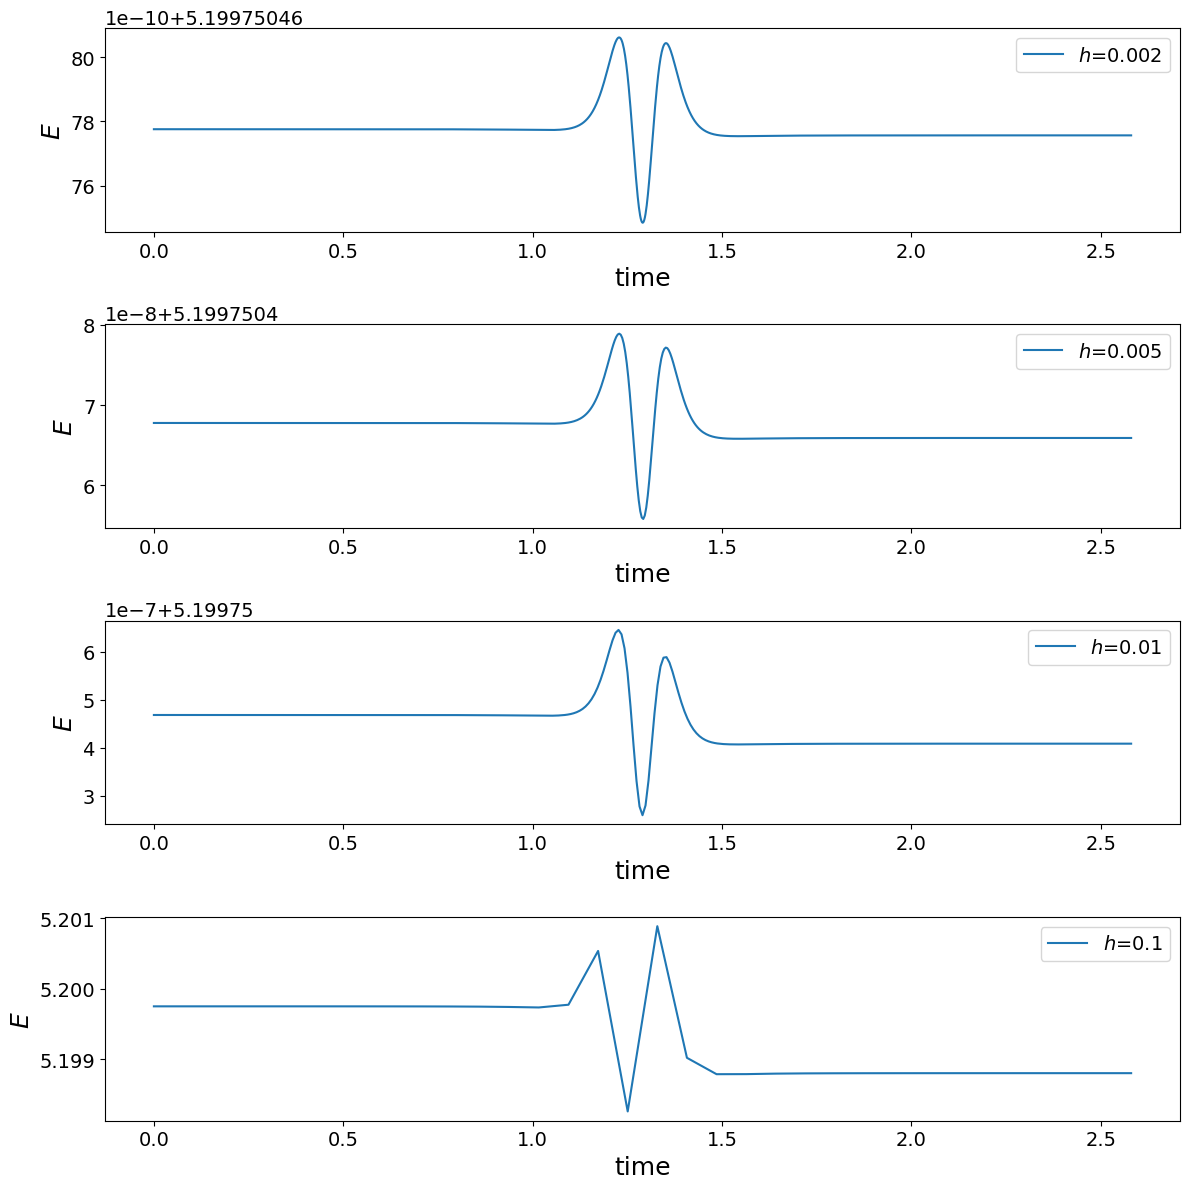

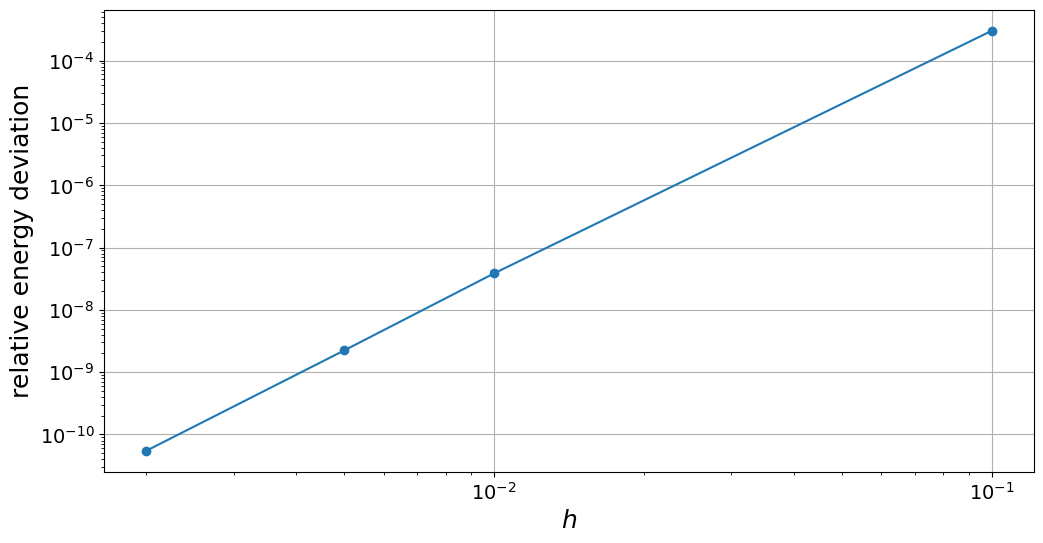

In [11]:
# Set initial conditions
E, b = 5, 0.25
x0, y0 = -5, b
vx0, vy0 = np.sqrt(2*E), 0
state = np.array([x0, y0, vx0, vy0])

# Iterate through different values of h obtaining the energies
h_values = [0.002, 0.005, 0.01, 0.1]
fig, ax = plt.subplots(len(h_values), 1, figsize=(12, 12))
energy_errors = []

for i, h in enumerate(h_values):
    data = [state.copy()]
    energies = [total_energy(state)]
    data, energies = RK4(state, data, Coloumb_acceleration, rmax=5, energies=energies, obtain_energies=True)    
    energy_errors.append( (max(energies)-np.mean(energies))/np.mean(energies) )
    times = np.linspace(0, transit_time, len(data))
    ax[i].plot(times, energies, label=f'$h$={h}')
    ax[i].legend()
    ax[i].set_xlabel('time')
    ax[i].set_ylabel('$E$')

plt.tight_layout()
plt.show()

plt.loglog(h_values, energy_errors, marker='o')
plt.xlabel('$h$')
plt.ylabel('relative energy deviation')
plt.grid()
plt.show()

### c) What happens as the initial $E$ is reduced

Lower $E$ means lower $v_x$ and therefore a lower initial velocity. This causes an increase in the transition time also causing an increase in scattering angle as the particle spends a longer time under the potential field. A decreased $E$ also improves the accuracy of the solution significantly since the initial speed is lower and each step cover a lower length of the path the paricle has gone through.

The transit time is 12.82 dimensionless units of time.
The scattering angle is 2.844 rad, 162.9º


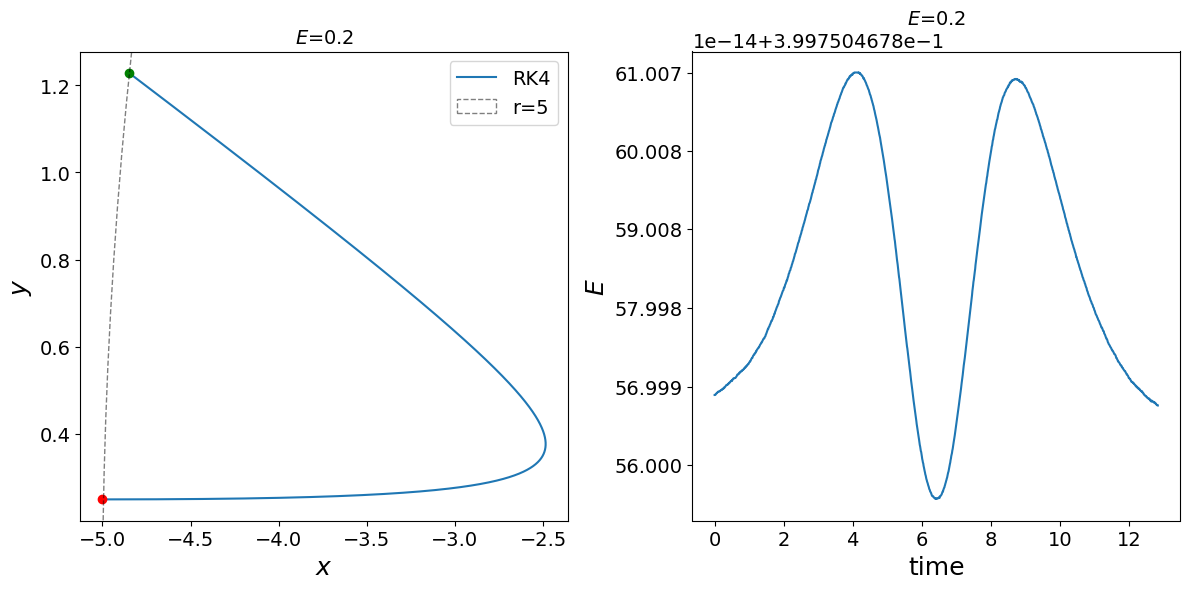

The transit time is 7.5 dimensionless units of time.
The scattering angle is 2.135 rad, 122.3º


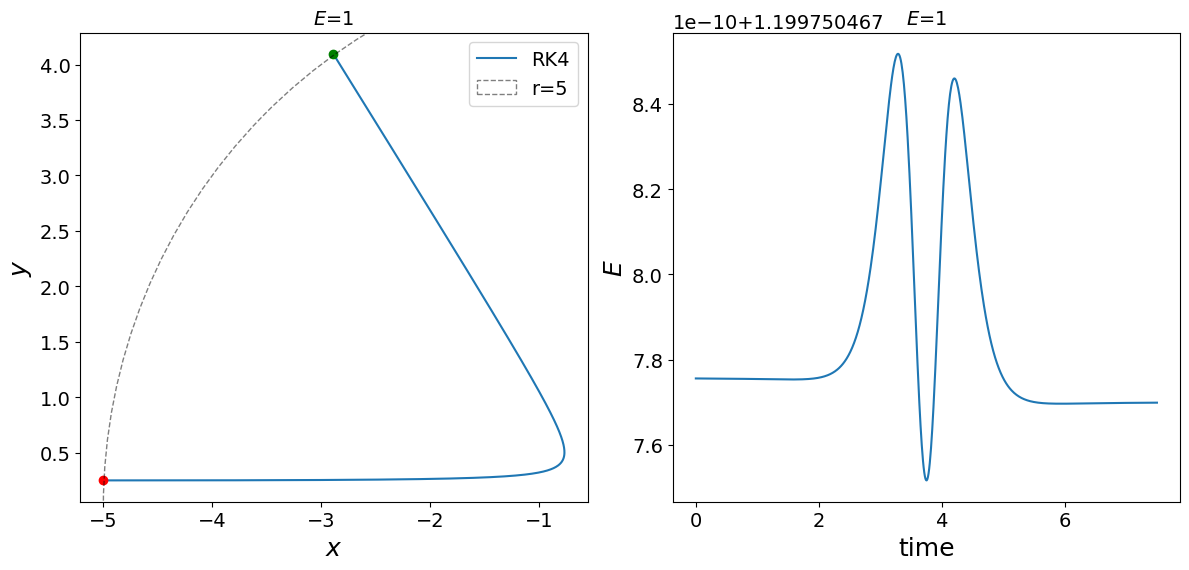

The transit time is 3.27 dimensionless units of time.
The scattering angle is 0.7466 rad, 42.78º


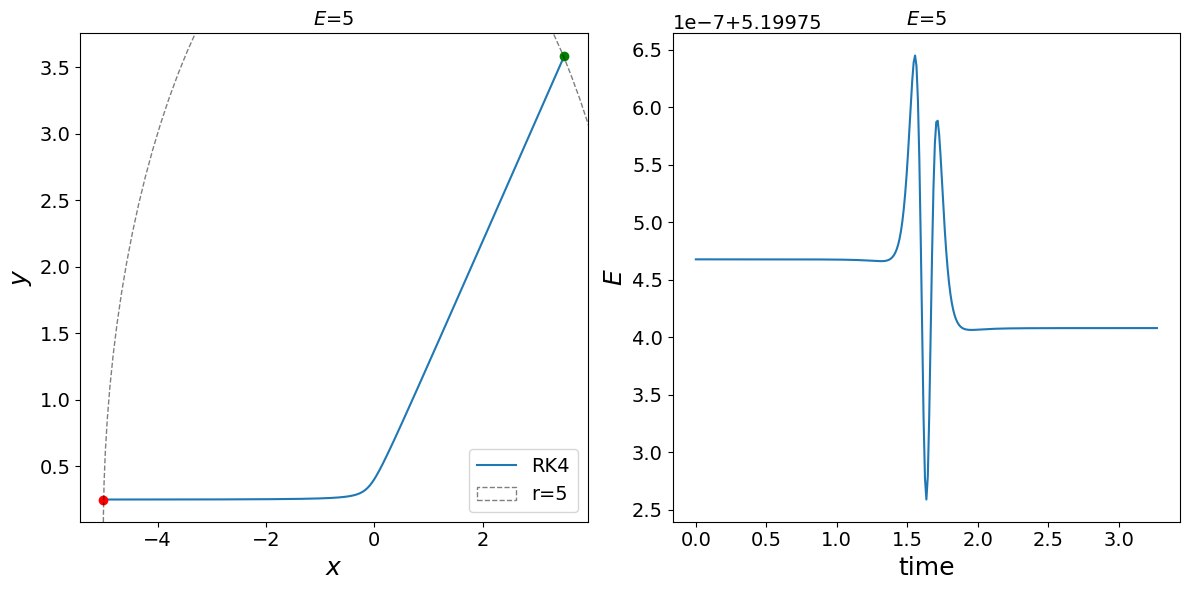

The transit time is 2.29 dimensionless units of time.
The scattering angle is 0.3905 rad, 22.37º


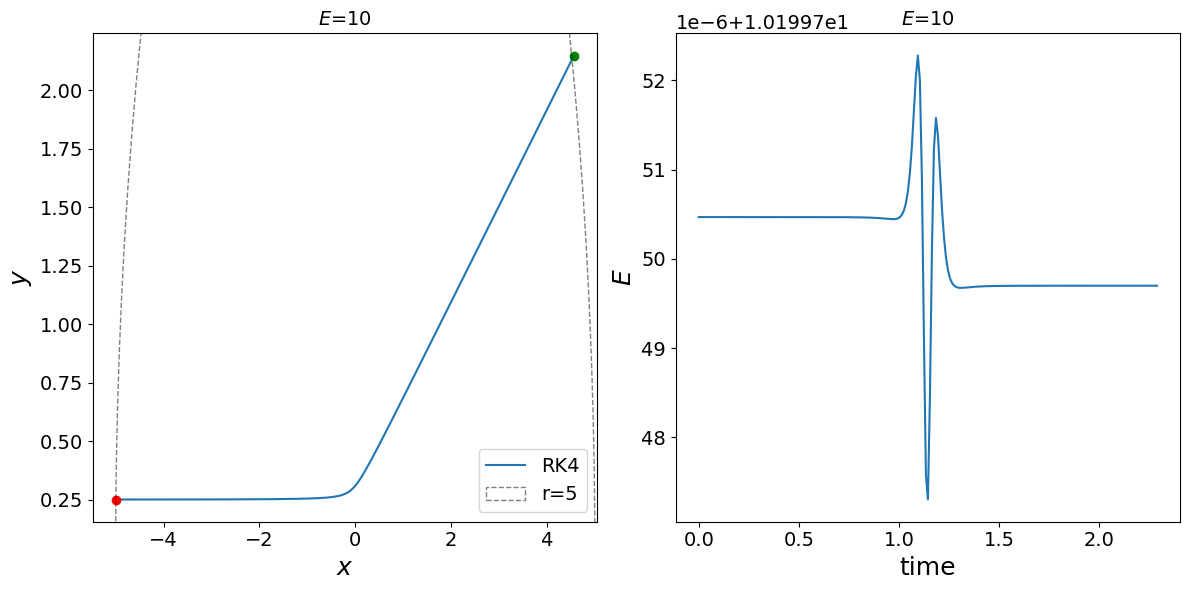

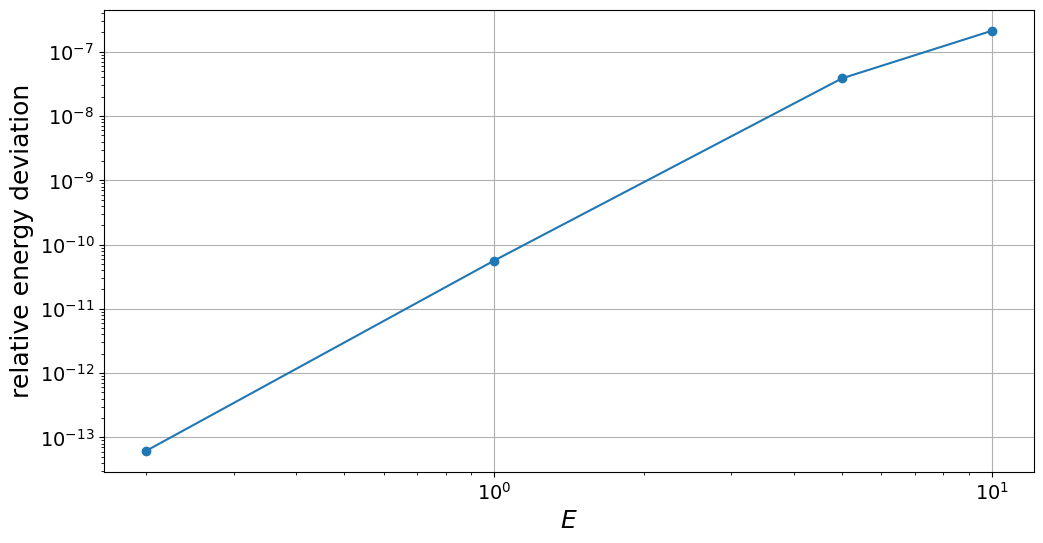

In [9]:
# Set initial conditions
b = 0.25
h = 0.01
x0, y0 = -5, b

# Iterate through different values of E
E_values = [0.2, 1, 5, 10]
energy_errors = []
for E in E_values:
    vx0, vy0 = np.sqrt(2*E), 0
    state = np.array([x0, y0, vx0, vy0])

    # Initialize and record the data using RK4
    data = [state.copy()]
    energies = [total_energy(state)]
    data, energies = RK4(state, data, Coloumb_acceleration, rmax=5, energies=energies, obtain_energies=True)
    energy_errors.append( (max(energies)-np.mean(energies))/np.mean(energies) )

    # Calculate the transit time and the scattering angle
    transit_time = len(data) * h
    scattering_angle = np.arctan2(data[-1,3], data[-1,2])
    print(f"The transit time is {transit_time:.4g} dimensionless units of time.\nThe scattering angle is {scattering_angle:.4g} rad, {np.degrees(scattering_angle):.4g}º")

    # subplotting
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot scattering
    ax[0].plot(data[:,0], data[:,1], zorder=0, label='RK4')
    ax[0].scatter(data[0,0], data[0,1], color='r')
    ax[0].scatter(data[-1,0], data[-1,1], color='g') 
    circle = Circle((0,0), 5, fill=False, color='k', linestyle='--', alpha=0.5, label='r=5')
    ax[0].add_patch(circle)
    ax[0].autoscale(False)
    ax[0].set_title(f'$E$={E}')
    ax[0].set_xlabel('$x$')
    ax[0].set_ylabel('$y$')
    ax[0].legend()
    
    # Plot accuracy of solution
    times = np.linspace(0, transit_time, len(data))
    ax[1].plot(times, energies)
    ax[1].set_title(f'$E$={E}')
    ax[1].set_xlabel('time')
    ax[1].set_ylabel('$E$')

    plt.tight_layout()
    plt.show()

plt.loglog(E_values, energy_errors, marker='o')
plt.xlabel('$E$')
plt.ylabel('relative energy deviation')
plt.grid()
plt.show()

### d) How the impact parameter $b$ affects the transit time and the scattering angle on an attractive potential

A higher value of $b$ means the particle starts further away from the origin of the potential therefore being less affected by it (since $V=-1/r$) and having a smaller deviation and smaller absolute value of the scattering angle. It also means the accuracy of the solution is improved although this is mostly affected by the time step and the length covered in each step (i.e. the initial velocity, dependeant on $E$). 

It is only necessary to test the positive values of $b$ since the potential is symmetric with respect to the x-axis meaning the time step will be symmetrical $t(-b)=t(b)$ and the scattering angle will be antisymmetrical $\theta(-b)=-\theta(b)$.

b=0: transit time=1.60 dimensionless units of time
     scattering angle=180.00º



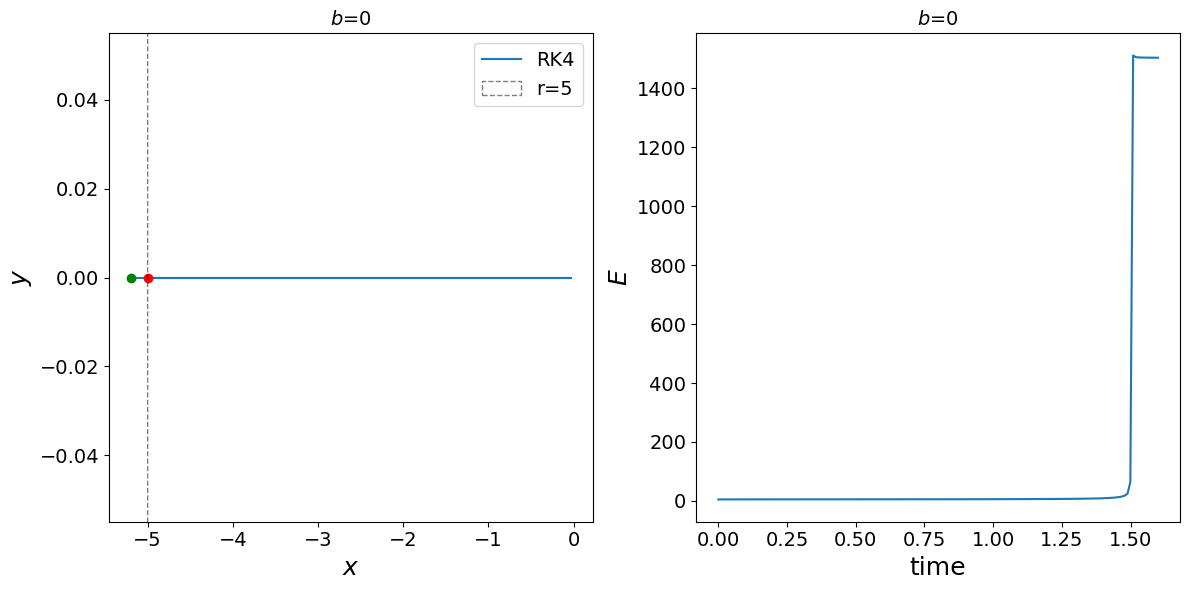

b=1: transit time=3.12 dimensionless units of time
     scattering angle=-11.42º



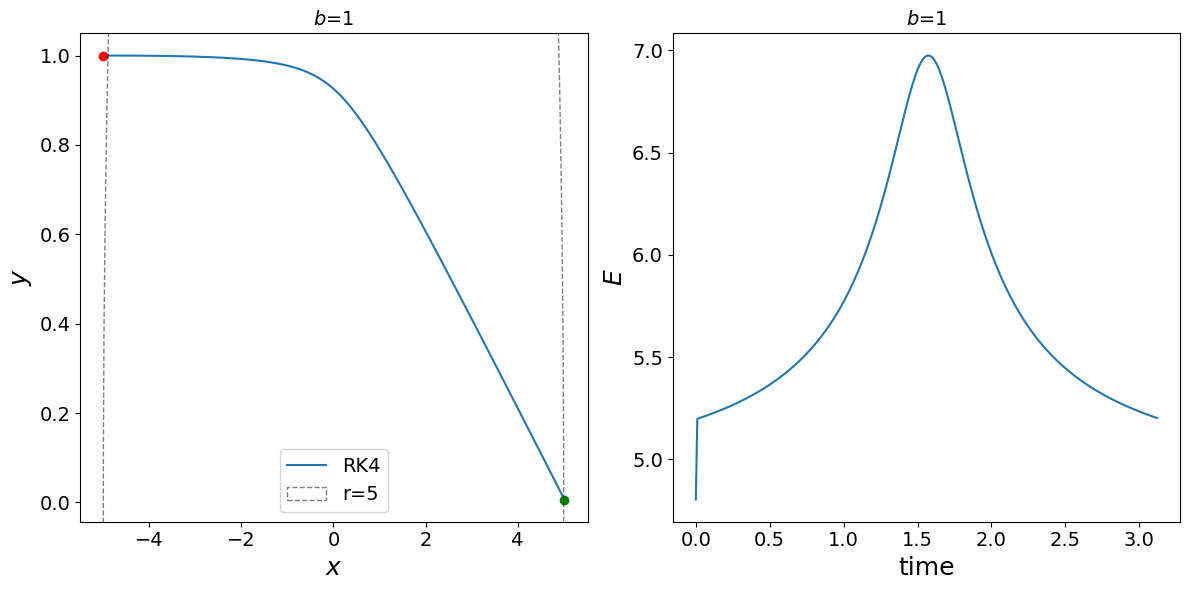

b=2: transit time=3.06 dimensionless units of time
     scattering angle=-5.38º



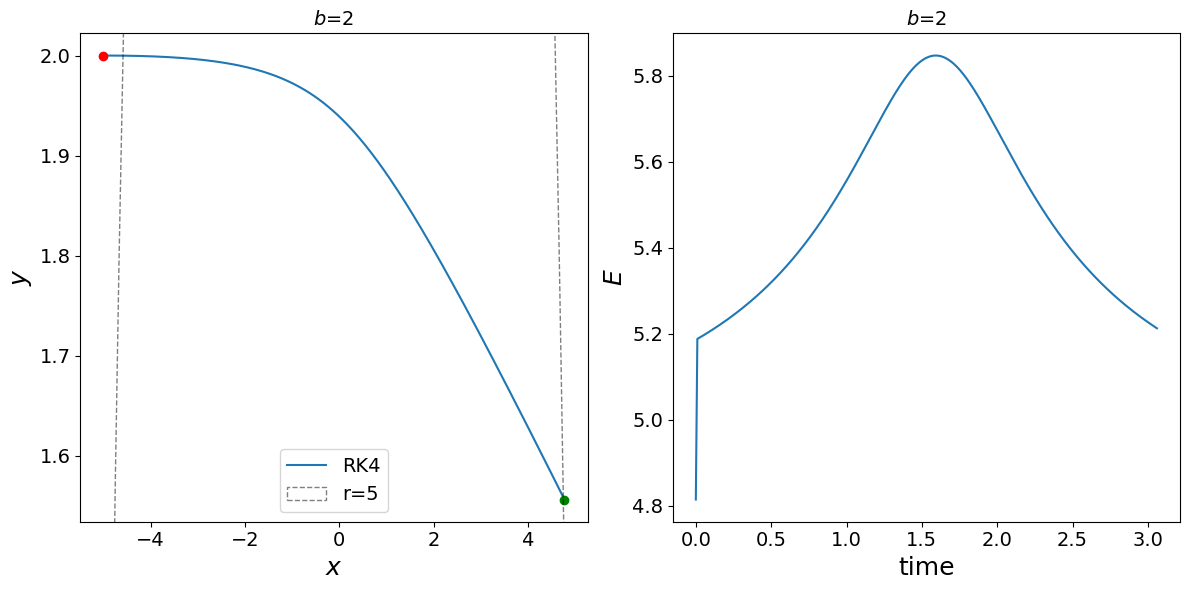

b=3: transit time=2.89 dimensionless units of time
     scattering angle=-3.23º



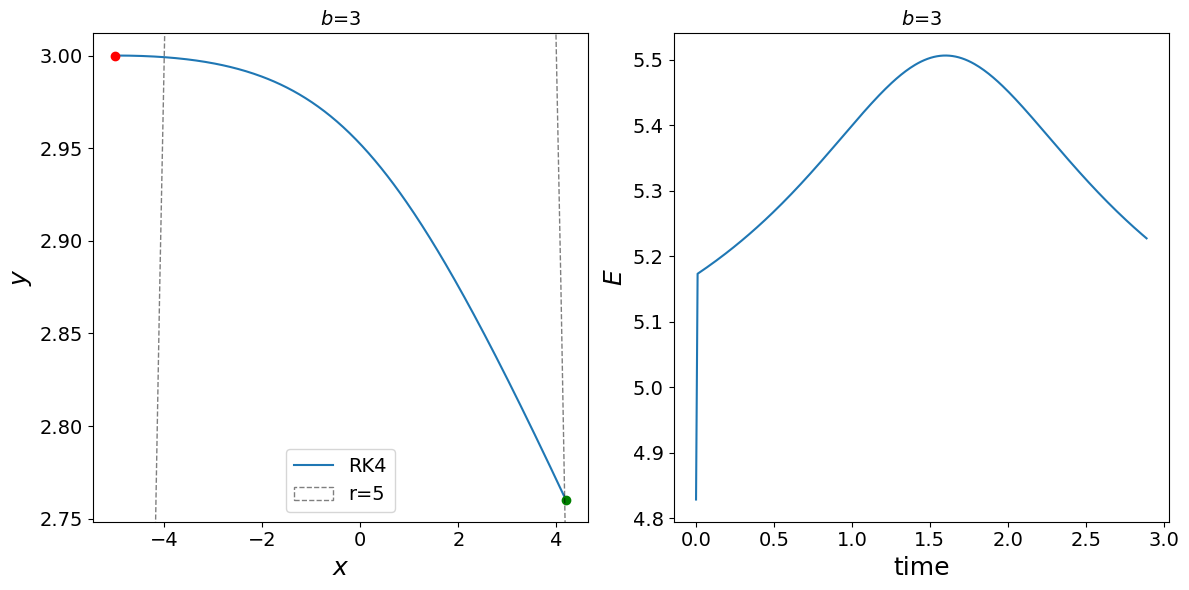

b=4: transit time=2.58 dimensionless units of time
     scattering angle=-2.02º



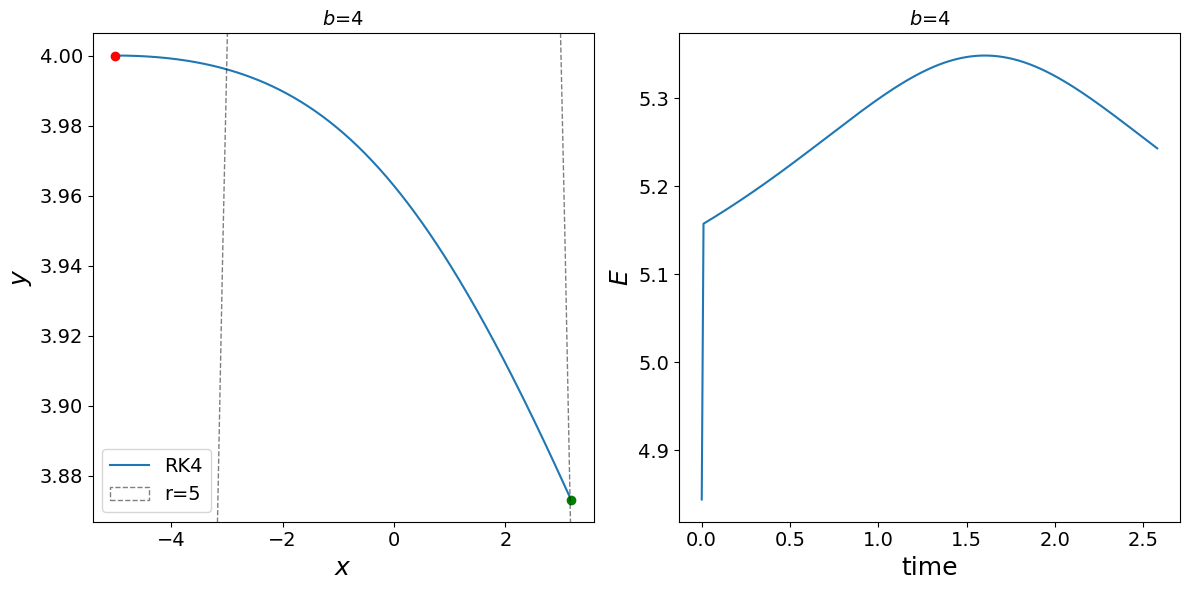

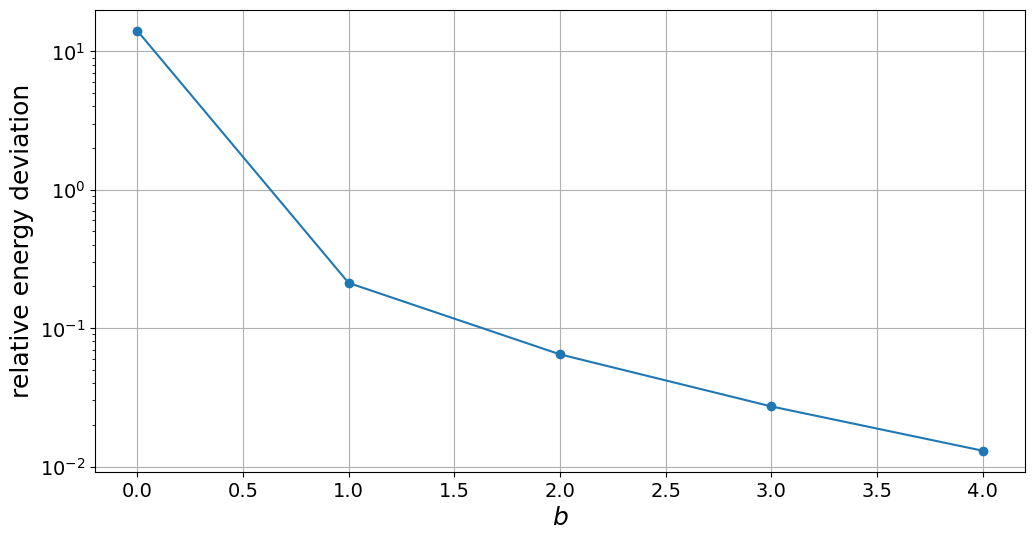

In [10]:
# Set initial conditions
E = 5
h = 0.01

b_values = np.arange(0, 5, 1)
energy_errors = []
for b in b_values:
    x0, y0 = -5, b
    vx0, vy0 = np.sqrt(2*E), 0
    state = np.array([x0, y0, vx0, vy0])
    
    # Initialize and record the data using RK4
    data = [state.copy()]
    energies = [total_energy(state, repulsive=False)]
    data, energies = RK4(state, data, Coloumb_acceleration, rmax=5, energies=energies, obtain_energies=True, repulsive=False)
    energy_errors.append( (max(energies)-np.mean(energies))/np.mean(energies) )

    # Calculate transit time and scatttering angle
    transit_time = len(data) * h
    scattering_angle = np.arctan2(data[-1,3], data[-1,2])   # np.arctan() does element-wise, np.arctan2() not
    print(f"b={b}: transit time={transit_time:.2f} dimensionless units of time\n     scattering angle={np.degrees(scattering_angle):.2f}º\n")

    # subplotting
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot scattering
    ax[0].plot(data[:,0], data[:,1], zorder=0, label='RK4')
    ax[0].scatter(data[0,0], data[0,1], color='r')
    ax[0].scatter(data[-1,0], data[-1,1], color='g') 
    circle = Circle((0,0), 5, fill=False, color='k', linestyle='--', alpha=0.5, label='r=5')
    ax[0].add_patch(circle)
    ax[0].autoscale(False)
    ax[0].set_title(f'$b$={b}')
    ax[0].set_xlabel('$x$')
    ax[0].set_ylabel('$y$')
    ax[0].legend()
    
    # Plot accuracy of solution
    times = np.linspace(0, transit_time, len(data))
    ax[1].plot(times, energies)
    ax[1].set_title(f'$b$={b}')
    ax[1].set_xlabel('time')
    ax[1].set_ylabel('$E$')

    plt.tight_layout()
    plt.show()

plt.semilogy(b_values, energy_errors, marker='o')
plt.xlabel('$b$')
plt.ylabel('relative energy deviation')
plt.grid()
plt.show()

## Chaotic Scattering